##steps followed
1. loading data and joining the data with transaction id
2. EDA. Missingness, target imbalance, quantitave over target(relationship) time ordered and correlation of features
3. Feature pruning. Cluster missingness then remove the redudant
4. Feature engineering. Categorical encoding, frequency encoding and target encoding.
5. Time split the data then train to get the baseline model
6. Add UID features then train the model and compare the results
7. GroupKFold time split.
8. Get the least important features and prune them

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
identity = pd.read_csv('/content/drive/MyDrive/ieee-fraud-detection/train_identity.csv')
transaction = pd.read_csv('/content/drive/MyDrive/ieee-fraud-detection/train_transaction.csv')
merged_data = pd.merge(transaction, identity, on='TransactionID' , how='inner')
merged_data.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,0,86535,15.000,H,2803,100.0,150.0,visa,226.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,0,86549,75.887,C,16496,352.0,117.0,mastercard,134.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,0,86555,16.495,C,4461,375.0,185.0,mastercard,224.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0,86620,30.000,H,1790,555.0,150.0,visa,226.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [ ]:
merged_data.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32
count,1.442330e+05,144233.000000,1.442330e+05,144233.000000,144233.000000,143331.000000,144061.000000,143277.000000,83786.000000,83786.000000,...,139369.000000,45113.000000,139318.000000,139261.000000,5159.000000,5169.000000,4747.000000,5132.000000,5163.000000,77586.000000
mean,3.236329e+06,0.078470,6.166958e+06,83.554533,9879.012528,391.325526,161.695504,191.166293,296.845058,86.198088,...,189.451377,14.237337,353.128174,403.882666,368.269820,16.002708,12.800927,329.608924,149.070308,26.508597
std,1.788496e+05,0.268911,4.807714e+06,99.850258,5047.643179,160.327848,19.410116,44.774337,99.307179,5.645163,...,30.375360,1.561302,141.095343,152.160327,198.847038,6.897665,2.372447,97.461089,32.101995,3.737502
min,2.987004e+06,0.000000,8.650600e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,...,100.000000,10.000000,100.000000,100.000000,100.000000,10.000000,11.000000,100.000000,100.000000,0.000000
25%,3.077142e+06,0.000000,1.885289e+06,25.453000,5713.000000,264.000000,150.000000,138.000000,204.000000,87.000000,...,166.000000,13.000000,266.000000,256.000000,252.000000,14.000000,11.000000,321.000000,119.000000,24.000000
50%,3.198818e+06,0.000000,4.913738e+06,50.000000,9633.000000,408.000000,150.000000,224.000000,299.000000,87.000000,...,166.000000,15.000000,341.000000,472.000000,252.000000,14.000000,11.000000,321.000000,149.000000,24.000000
75%,3.392923e+06,0.000000,1.025794e+07,100.000000,15063.000000,545.000000,185.000000,226.000000,330.000000,87.000000,...,225.000000,15.000000,427.000000,533.000000,486.500000,14.000000,15.000000,371.000000,169.000000,32.000000
max,3.577534e+06,1.000000,1.581103e+07,1800.000000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,...,229.000000,29.000000,671.000000,661.000000,854.000000,44.000000,26.000000,548.000000,216.000000,32.000000


In [ ]:
#class imbalance
count = merged_data['isFraud'].value_counts()
percentage = merged_data['isFraud'].value_counts(normalize=True)*100

class_imbalance= pd.DataFrame({
    "count": count,
    "percentage": percentage
})
class_imbalance

,count,percentage
isFraud,,
0,132915,92.152975
1,11318,7.847025


In [ ]:
#time ordered check
merged_data['TransactionDT'].describe()

,TransactionDT
count,1.442330e+05
mean,6.166958e+06
std,4.807714e+06
min,8.650600e+04
25%,1.885289e+06
50%,4.913738e+06
75%,1.025794e+07
max,1.581103e+07


In [ ]:
merged_data.sort_values('TransactionDT').head()



,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,0,86535,15.000,H,2803,100.0,150.0,visa,226.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,0,86549,75.887,C,16496,352.0,117.0,mastercard,134.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,0,86555,16.495,C,4461,375.0,185.0,mastercard,224.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0,86620,30.000,H,1790,555.0,150.0,visa,226.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [ ]:
merged_data.sort_values('TransactionDT').tail()


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
144228,3577521,0,15810802,48.877,C,12019,305.0,106.0,mastercard,224.0,...,chrome 66.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,F3111 Build/33.3.A.1.97
144229,3577526,1,15810876,250.000,R,1214,174.0,150.0,visa,226.0,...,chrome 55.0 for android,32.0,855x480,match_status:2,T,F,T,F,mobile,A574BL Build/NMF26F
144230,3577529,0,15810912,73.838,C,5096,555.0,185.0,mastercard,137.0,...,chrome 65.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,Moto E (4) Plus Build/NMA26.42-152
144231,3577531,0,15810935,400.000,R,6019,583.0,150.0,visa,226.0,...,chrome 66.0,24.0,2560x1600,match_status:2,T,F,T,F,desktop,MacOS
144232,3577534,0,15811030,67.505,C,5812,408.0,185.0,mastercard,224.0,...,chrome 66.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,RNE-L03 Build/HUAWEIRNE-L03


In [ ]:
#train test time gap
test_data = pd.read_csv('/content/drive/MyDrive/ieee-fraud-detection/test_transaction.csv')
train_max = merged_data['TransactionDT'].max()
train_min = merged_data['TransactionDT'].min()
test_max = test_data['TransactionDT'].max()
test_min = test_data['TransactionDT'].min()
print(train_max, test_min)

15811030 18403224


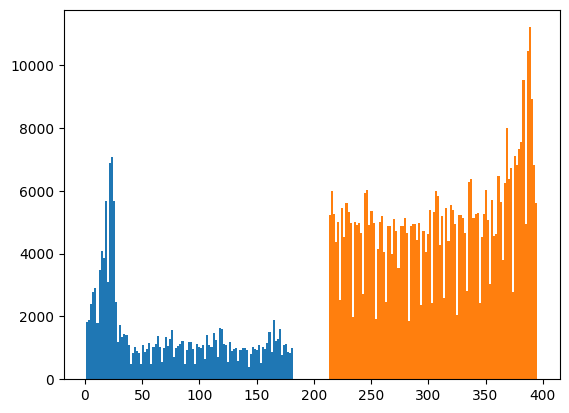

In [ ]:

merged_data['bin'] = merged_data['TransactionDT'] // (24*60*60)
test_data['bin']  = test_data['TransactionDT'] // (24*60*60)
plt.hist(merged_data['bin'], bins=100)
plt.hist(test_data['bin'], bins=100)
plt.show()



In [ ]:
#check if quantitative feature transaction amount has an effect on the target
fraud_amt = merged_data[merged_data['isFraud'] == 1]['TransactionAmt']
nonfraud_amt = merged_data[merged_data['isFraud'] == 0]['TransactionAmt']


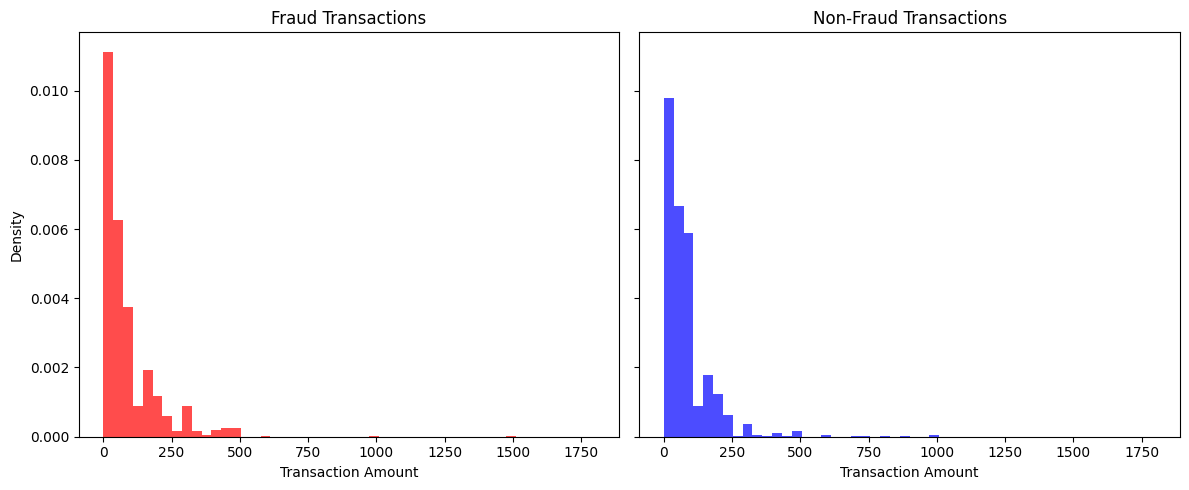

In [ ]:

#histogram plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
#fraud
axes[0].hist(fraud_amt,bins=50,alpha=0.7,color='red',density=True)
axes[0].set_title("Fraud Transactions")
axes[0].set_xlabel("Transaction Amount")
axes[0].set_ylabel("Density")
# Non-Fraud
axes[1].hist(nonfraud_amt,bins=50,alpha=0.7,color='blue',density=True)
axes[1].set_title("Non-Fraud Transactions")
axes[1].set_xlabel("Transaction Amount")
plt.tight_layout()
plt.show()


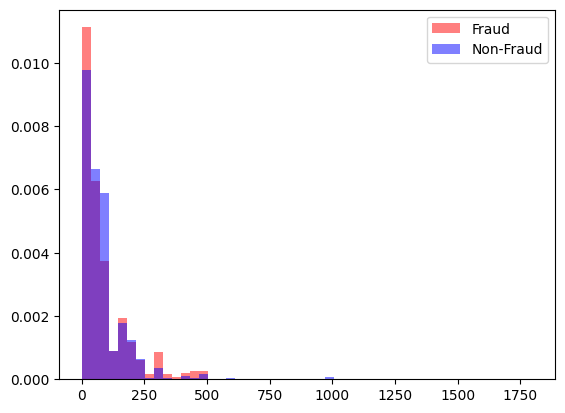

In [ ]:
#overlaid histogram
plt.hist(fraud_amt, bins=50, alpha=0.5, label='Fraud', color='red', density=True)
plt.hist(nonfraud_amt, bins=50, alpha=0.5, label='Non-Fraud', color='blue', density=True)
plt.legend()
plt.show()

In [ ]:
#missing values
missing_pct = merged_data.isna().mean().sort_values(ascending=False)*100
missing_pct


,0
V10,100.0
V11,100.0
V8,100.0
V9,100.0
V7,100.0
...,...
TransactionAmt,0.0
isFraud,0.0
TransactionDT,0.0
TransactionID,0.0


## Missingingness analysis
V and Id columns are engineered generated features with a lot of missing values(NAN). To determine whether the missingness is structured or redudant the columns are searched to find those that shared a similar NaN structure and grouped. With each missingness group highly correlated columns are pruned and keeping the ones with unique values


In [ ]:

#identify V and ID columns
def get_v_id_cols(df):
  v_cols = [col for col in df.columns if col.startswith('V')]
  id_cols = [col for col in df.columns if col.startswith('id_')]
  return v_cols, id_cols

#missing percentage
def missing_report(df,cols,top_n=30):
  if cols is None:
    cols = df.columns
  rep = (
      df[cols].isna().mean().sort_values(ascending=False)
      .to_frame('missing_pct')
  ) # creates a datafreame for the missing percemtage of each column
  rep['missing_cnt'] = df[cols].isna().sum().loc[rep.index].values #missing count
  rep['non_missing_cnt'] = df.shape[0]-rep['missing_cnt']

  return rep.head(top_n)

# Group columns by identical NAN mask
def group_by_missing_pattern(df, cols,min_non_missing=100):
  """
  group columns by their missingness pattern using a hash signature.
  - min_non_missing: ignore columns with too few observed values(noisy)
  returns dict{hash: [cols]}
    """
  X = df[cols]
  non_missing = X.notna().sum()

# keeping only columns with enough observed values to be meaningful
  keep_cols = non_missing[non_missing>=min_non_missing].index.tolist()
  X = X[keep_cols]

  #Nan mask (true if missing)
  mask = X.isna()

  #build a stable signature for eavh column's missingness vector.
  #using pandas hashing to avoid huge strings
  sig = {}
  for c in mask.columns:
    # hash_pandas_object gives per-row hashes; sum them for a compact signature
        # (good enough for grouping identical patterns in practice)
    sig[c] = pd.util.hash_pandas_object(mask[c], index=False).sum()
  #group columns by signature
  groups = {}
  for c, s in sig.items():
    groups.setdefault(s,[]).append(c)

  #sort groups by size(largest first)
  groups = dict(sorted(groups.items(), key=lambda x: len(x[1]), reverse=True))
  return groups

#correlation pruning within each missingness group ( keep 1 per blob)
def prune_correlated_within_group(df,cols,corr_thresh=0.75,min_periods=1000):
  """
  Given a list of columns with similar missingness structure
  prune highly correlated ones (/r/ > corr-thresh).
  Strategy:
  -sort columns by n_unique desc(keep most informative first)
  -greedy keep: keep a col if not highly correlated with already-kept cols
  returns: kept_cols, dropped_cols """
  X = df[cols]
  #choose most informative as highest number of unique non- null values

  nunique = X.nunique(dropna=True).sort_values(ascending=False)
  ordered = nunique.index.tolist()

  kept = []
  dropped = []
 # precompute correlation incrementally for speed
 # compute correlation of candidate with already kept cols only

  for c in ordered:
    if not kept:
      kept.append(c)
      continue
    #corr wit kept columns; handle missing values pairwise
    corr = X[kept + [c]].corr(min_periods=min_periods)[c].drop(index=c) #pearson correlation, min_periods quality gate ifa column in kept is less than min_periods, the result for that pair will be NaN.

    #if any high correlation -> drop
    if (corr.abs() > corr_thresh).any():
      dropped.append(c)
    else:
      kept.append(c)
  return kept, dropped
#missingness grouping + correlation pruning pipeline
def missingness_prune_pipeline(df,cols,min_non_missing=100,corr_thresh=0.75,min_periods=1000,min_group_size=2):
  """
Group columns by missingness signature
for the groups with size >= min_group_size, prunes correlated columns
returns :
kept_cols: final kept columns
dropped_cols: final dropped columns
debug: data frame summary per group  """
  groups = group_by_missing_pattern(df, cols, min_non_missing)#a dictionary of missingness group
  all_kept =[]
  all_dropped = []
  summary_rows = []

  for gkey, gcols in groups.items():
   if len(gcols) < min_group_size:
    #keep singletons by default (they may be unique signals)
    all_kept.extend(gcols)
    summary_rows.append({
        "group_size": len(gcols),
        "kept":len(gcols),
        "dropped":0,
        "group_key": gkey
    })
    continue
  kept, dropped = prune_correlated_within_group(df, gcols, corr_thresh, min_periods)
  all_kept.extend(kept)
  all_dropped.extend(dropped)
  summary_rows.append({
      "group_size": len(gcols),
      "kept":len(kept),
      "dropped":len(dropped),
      "note": 'pruned_by_corr'
  })
  debug= pd.DataFrame(summary_rows).sort_values(
      by=["group_size", "dropped"], ascending=False
  ).reset_index(drop=True)

  # Ensure uniqueness
  all_kept = list(dict.fromkeys(all_kept))
  all_dropped = list(dict.fromkeys(all_dropped))

  return all_kept, all_dropped, debug




In [ ]:
#get top 30 v and ID columns
v_cols, id_cols = get_v_id_cols(merged_data)
print("Top missing V columns:")
display(missing_report(merged_data, v_cols, top_n=30))


Top missing V columns:


,missing_pct,missing_cnt,non_missing_cnt
V1,1.000000,144233,0
V2,1.000000,144233,0
V6,1.000000,144233,0
V3,1.000000,144233,0
V4,1.000000,144233,0
V5,1.000000,144233,0
V8,1.000000,144233,0
V7,1.000000,144233,0
V9,1.000000,144233,0
V10,1.000000,144233,0


In [ ]:
len(v_cols),len(id_cols)

(339, 38)

In [ ]:
print("Top missing id columns:")
display(missing_report(merged_data, id_cols, top_n=30))

Top missing id columns:


,missing_pct,missing_cnt,non_missing_cnt
id_24,0.967088,139486,4747
id_25,0.964419,139101,5132
id_08,0.964259,139078,5155
id_07,0.964259,139078,5155
id_21,0.964231,139074,5159
id_26,0.964204,139070,5163
id_27,0.964162,139064,5169
id_22,0.964162,139064,5169
id_23,0.964162,139064,5169
id_18,0.687221,99120,45113


In [ ]:
# run the pruning pipeline on both v and id columns
kept_v, dropped_v, debug_v = missingness_prune_pipeline(
    merged_data, v_cols,
    min_non_missing=100,      # tune: 50–500 depending on size
    corr_thresh=0.75,
    min_periods=500,
    min_group_size=2
)
kept_id, dropped_id, debug_id = missingness_prune_pipeline(
    merged_data, id_cols,
    min_non_missing=100,
    corr_thresh=0.75,
    min_periods=500,
    min_group_size=2
)

In [ ]:
print("V pruning summary:")
display(debug_v.head(10))

V pruning summary:


,group_size,kept,dropped,note
0,11,7,4,pruned_by_corr


In [ ]:
print("id pruning summary:")
display(debug_id.head(10))

id pruning summary:


,group_size,kept,dropped,group_key,note
0,1,1,0,1.066124e+19,NaN
1,1,1,0,7.595028e+18,NaN
2,1,1,0,1.062475e+19,NaN
3,1,1,0,5.814280e+18,NaN
4,1,1,0,1.553859e+19,NaN
5,1,1,0,1.356169e+18,NaN
6,1,1,0,1.638906e+18,NaN
7,1,1,0,6.720915e+18,NaN
8,1,1,0,3.355561e+18,NaN
9,1,1,0,9.344106e+18,NaN


In [ ]:
print(f"V cols: start={len(v_cols)}, kept={len(kept_v)}, dropped={len(dropped_v)}")

V cols: start=339, kept=7, dropped=4


In [ ]:
print(f"id cols: start={len(id_cols)}, kept={len(kept_id)}, dropped={len(dropped_id)}")

id cols: start=38, kept=17, dropped=0


Missingness-aware pruning grouped features by identical NaN patterns and removed highly correlated duplicates within each group. This resulted in the removal of 4 V-features; no ID-features met grouping criteria and were retained.

In [ ]:
# columns to drop
cols_to_drop = set(dropped_v) | set(dropped_id)

# reduced dataset
merged_data_pruned = merged_data.drop(columns=cols_to_drop, errors="ignore")

print("Original shape:", merged_data.shape)
print("Reduced shape :", merged_data_pruned.shape)
print("Dropped cols  :", len(cols_to_drop))


Original shape: (144233, 435)
Reduced shape : (144233, 431)
Dropped cols  : 4


##Feature Engineering

1. Categorical preprocessing.
2. Frequency encoding.
3. Aggregate encoding


In [ ]:

# Helpers

def _safe_str_series(s: pd.Series) -> pd.Series:
    """Convert to string while preserving NaN as a literal category."""
    return s.astype("object").fillna("__NA__").astype(str)

def _ensure_cols_exist(df: pd.DataFrame, cols):
    return [c for c in cols if c in df.columns]
def _add_missing_cols(df: pd.DataFrame, cols, fill_value=np.nan) -> pd.DataFrame:
    """Ensure df has all cols; add missing with fill_value."""
    df = df.copy()
    for c in cols:
        if c not in df.columns:
            df[c] = fill_value
    return df



# STEP 1 — Categorical preprocessing (Factorize / Ordinal)

def fit_factorize_maps(train_df: pd.DataFrame, cat_cols):
    """
    Build mapping dicts {col: {category_str: int_code}} from TRAIN only.
    Unknown categories at transform time -> -1.
    """
    maps = {}
    for c in cat_cols:
        s = _safe_str_series(train_df[c])
        # Factorize gives codes 0..K-1 in order of appearance
        uniques = pd.Index(s.unique())
        maps[c] = {val: i for i, val in enumerate(uniques)}
    return maps

def transform_with_maps(df: pd.DataFrame, maps):
    """Apply pre-fitted maps to any dataframe (train/valid/test)."""
    out = df.copy()
    for c, mp in maps.items():
        if c not in out.columns:
            out[c] = np.nan
        s = _safe_str_series(out[c])
        out[c] = s.map(mp).fillna(-1).astype("int32")
    return out



# STEP 2 — Frequency encoding (FE)
def fit_frequency_maps(train_df: pd.DataFrame, fe_cols):
    """
    Create {col: {category_str: count}} maps from TRAIN only.
    """
    maps = {}
    for c in fe_cols:
        s = _safe_str_series(train_df[c])
        maps[c] = s.value_counts(dropna=False).to_dict()
    return maps

def add_frequency_encoded(df: pd.DataFrame, fe_maps, suffix="_FE"):
    """
    Add frequency encoded columns using precomputed train counts.
    Unknown categories -> 0.
    """
    out = df.copy()
    for c, mp in fe_maps.items():
        if c not in out.columns:
          out[c] = np.nan
        s = _safe_str_series(out[c])
        out[f"{c}{suffix}"] = s.map(mp).fillna(0).astype("int32")
    return out



# STEP 3 — Aggregation encoding (mean/std TransactionAmt)

def fit_agg_tables(train_df: pd.DataFrame, group_cols_list, target_col="TransactionAmt"):
    """
    For each grouping key (e.g., ["card1"] or ["card1","addr1"]),
    compute mean/std of target on TRAIN only.
    Returns dict keyed by a name string -> agg table.
    """
    agg_tables = {}
    for group_cols in group_cols_list:
        key_name = "_".join(group_cols)
        g = train_df.groupby(group_cols)[target_col].agg(["mean", "std"]).reset_index()
        g.rename(columns={
            "mean": f"{target_col}_{key_name}_mean",
            "std":  f"{target_col}_{key_name}_std",
        }, inplace=True)
        agg_tables[key_name] = g
    return agg_tables

def add_agg_features(df: pd.DataFrame, agg_tables, group_cols_list):
    """
    Merge agg tables into df. Missing groups (unseen in train) remain NaN;
    fill with global stats after merge for stability.
    """
    out = df.copy()

    # global fallback stats (computed from df itself OR pass from train; here use df)
    # Better: compute from TRAIN and pass in; but this is fine for notebook-level.
    global_mean = out["TransactionAmt"].mean()
    global_std  = out["TransactionAmt"].std()

    for group_cols in group_cols_list:
        key_name = "_".join(group_cols)
        out = out.merge(agg_tables[key_name], on=group_cols, how="left")

        mean_col = f"TransactionAmt_{key_name}_mean"
        std_col  = f"TransactionAmt_{key_name}_std"

        out[mean_col] = out[mean_col].fillna(global_mean).astype("float32")
        out[std_col]  = out[std_col].fillna(global_std).astype("float32")

    return out



# End-to-end feature preprocessing pipeline

def preprocess_features(train_df: pd.DataFrame, test_df: pd.DataFrame):
    """
    Returns:
      X_train_processed, X_test_processed, artifacts(dict)
    """
    Xtr = train_df.copy()
    Xte = test_df.copy()

    # ---- Define columns ----
    cat_cols = [
        # cards
        "ProductCD", "card1", "card2", "card3", "card4", "card5", "card6",
        # address
        "addr1", "addr2",
        # emails
        "P_emaildomain", "R_emaildomain",
        # device
        "DeviceType", "DeviceInfo",
    ]
    cat_cols = _ensure_cols_exist(Xtr, cat_cols)

    # Frequency encoding columns (raw categorical, before factorization is ok)
    fe_cols = ["card1", "addr1", "P_emaildomain"]
    fe_cols = _ensure_cols_exist(Xtr, fe_cols)
    # ensure test has the raw cols we will reference
    Xte = _add_missing_cols(Xte, cat_cols)
    Xte = _add_missing_cols(Xte, fe_cols)



    # Combined FE key: card1 + addr1
    # We’ll create a combined column for both train and test.
    if "card1" in Xtr.columns and "addr1" in Xtr.columns:
        Xte = _add_missing_cols(Xte, ["card1", "addr1"])
        Xtr["card1_addr1"] = _safe_str_series(Xtr["card1"]) + "_" + _safe_str_series(Xtr["addr1"])
        Xte["card1_addr1"] = _safe_str_series(Xte["card1"]) + "_" + _safe_str_series(Xte["addr1"])
        fe_cols = fe_cols + ["card1_addr1"]

    # ---- Step 2 first (FE on raw categories) ----
    fe_maps = fit_frequency_maps(Xtr, fe_cols)
    Xtr = add_frequency_encoded(Xtr, fe_maps, suffix="_FE")
    Xte = add_frequency_encoded(Xte, fe_maps, suffix="_FE")

    # ---- Step 1 (factorize / ordinal encode) ----
    factor_maps = fit_factorize_maps(Xtr, cat_cols)
    Xtr = transform_with_maps(Xtr, factor_maps)
    Xte = transform_with_maps(Xte, factor_maps)

    # ---- Step 3 (aggregation encoding) ----
    group_cols_list = []
    if "card1" in Xtr.columns:
        group_cols_list.append(["card1"])
    if "card1" in Xtr.columns and "addr1" in Xtr.columns:
        group_cols_list.append(["card1", "addr1"])

    agg_tables = fit_agg_tables(train_df, group_cols_list, target_col="TransactionAmt")
    Xtr = add_agg_features(Xtr, agg_tables, group_cols_list)
    Xte = add_agg_features(Xte, agg_tables, group_cols_list)

    artifacts = {
        "cat_cols": cat_cols,
        "fe_cols": fe_cols,
        "factor_maps": factor_maps,
        "fe_maps": fe_maps,
        "agg_tables": agg_tables,
        "group_cols_list": group_cols_list,
    }
    return Xtr, Xte, artifacts


# ==================
# Example usage
# ==================
# train_merged: your merged train df with isFraud
# test_merged:  your merged test df

# Separate target
y = merged_data_pruned["isFraud"].astype(int)

X_train_processed, X_test_processed, artifacts = preprocess_features(
    merged_data_pruned.drop(columns=["isFraud"]),
    test_data
)

print("Processed train shape:", X_train_processed.shape)


/tmp/ipython-input-938685789.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return s.astype("object").fillna("__NA__").astype(str)
/tmp/ipython-input-938685789.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return s.astype("object").fillna("__NA__").astype(str)
/tmp/ipython-input-938685789.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcastin

Processed train shape: (144233, 439)


In [ ]:
print("Processed test shape:", X_test_processed.shape)


Processed test shape: (506691, 405)


In [ ]:

print("Added FE cols:", [c for c in X_train_processed.columns if c.endswith("_FE")])


Added FE cols: ['card1_FE', 'addr1_FE', 'P_emaildomain_FE', 'card1_addr1_FE']


In [ ]:

print("Added agg cols:", [c for c in X_train_processed.columns if "TransactionAmt_" in c and ("_mean" in c or "_std" in c)])

Added agg cols: ['TransactionAmt_card1_mean', 'TransactionAmt_card1_std', 'TransactionAmt_card1_addr1_mean', 'TransactionAmt_card1_addr1_std']


In [ ]:
# 1) Create month from TransactionDT
SECONDS_IN_DAY = 24 * 60 * 60
X_train_processed["month"] = (X_train_processed["TransactionDT"] // (30 * SECONDS_IN_DAY)).astype(int)

# 2) Build time-based split indices (train = all but last month, val = last month)
months_sorted = np.sort(X_train_processed["month"].unique())
train_months = months_sorted[:-1]
val_months   = months_sorted[-1:]

train_idx = X_train_processed["month"].isin(train_months)
val_idx   = X_train_processed["month"].isin(val_months)

# 3) Split train/val
X_tr, X_val = X_train_processed.loc[train_idx].copy(), X_train_processed.loc[val_idx].copy()
y_tr, y_val = y.loc[train_idx].copy(), y.loc[val_idx].copy()

# 4) Force numeric dtypes (fixes category/object issues for XGBoost)
X_tr  = X_tr.apply(pd.to_numeric, errors="coerce")
X_val = X_val.apply(pd.to_numeric, errors="coerce")
X_test_processed = X_test_processed.apply(pd.to_numeric, errors="coerce")

# 5) Define feature list (drop TransactionDT + month)
features = [c for c in X_tr.columns if c not in ["TransactionDT", "month"]]

print("n_features:", len(features))
print("X_tr shape:", X_tr[features].shape)
print("X_val shape:", X_val[features].shape)


n_features: 438
X_tr shape: (142762, 438)
X_val shape: (1471, 438)


In [ ]:



clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    enable_categorical=False,
    missing=np.nan,
    random_state=42
)


#features = [c for c in X_tr.columns if c not in ["TransactionDT", "month"]]



clf.fit(
    X_tr[features], y_tr,
    eval_set=[(X_val[features], y_val)],
    verbose=50
)


[0]	validation_0-auc:0.87944
[50]	validation_0-auc:0.94755
[100]	validation_0-auc:0.95534
[150]	validation_0-auc:0.95846
[200]	validation_0-auc:0.96091
[250]	validation_0-auc:0.96283
[300]	validation_0-auc:0.96326
[350]	validation_0-auc:0.96390
[400]	validation_0-auc:0.96428
[450]	validation_0-auc:0.96435
[499]	validation_0-auc:0.96510


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:


train_preds = clf.predict_proba(X_tr[features])[:,1]
val_preds   = clf.predict_proba(X_val[features])[:,1]

print("Train AUC:", roc_auc_score(y_tr, train_preds))
print("Val   AUC:", roc_auc_score(y_val, val_preds))


Train AUC: 0.9973539788863074
Val   AUC: 0.965100226852562


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

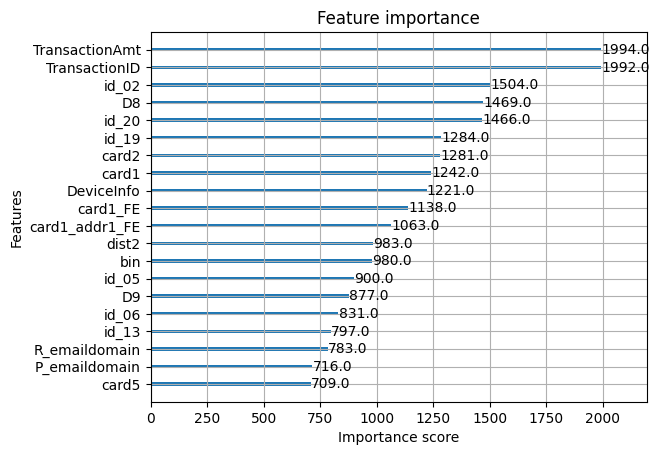

In [ ]:
xgb.plot_importance(clf, max_num_features=20)


In [ ]:



cols_to_drop = [
    "TransactionID",   # transaction identifier
    "bin",           # BIN
]

X_tr = X_tr.drop(columns=[c for c in cols_to_drop if c in X_tr.columns])
X_val = X_val.drop(columns=[c for c in cols_to_drop if c in X_val.columns])
X_test_processed = X_test_processed.drop(
    columns=[c for c in cols_to_drop if c in X_test_processed.columns]
)



clf_1 = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    missing=np.nan,
    random_state=42
)

clf_1.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    verbose=50,
    #early_stopping_rounds=50
)

val_preds = clf_1.predict_proba(X_val)[:, 1]
print("Val AUC:", roc_auc_score(y_val, val_preds))


[0]	validation_0-auc:0.88104
[50]	validation_0-auc:0.94856
[100]	validation_0-auc:0.95616
[150]	validation_0-auc:0.96135
[200]	validation_0-auc:0.96390
[250]	validation_0-auc:0.96535
[300]	validation_0-auc:0.96630
[350]	validation_0-auc:0.96664
[400]	validation_0-auc:0.96659
[450]	validation_0-auc:0.96731
[499]	validation_0-auc:0.96785
Val AUC: 0.9678531351669909


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

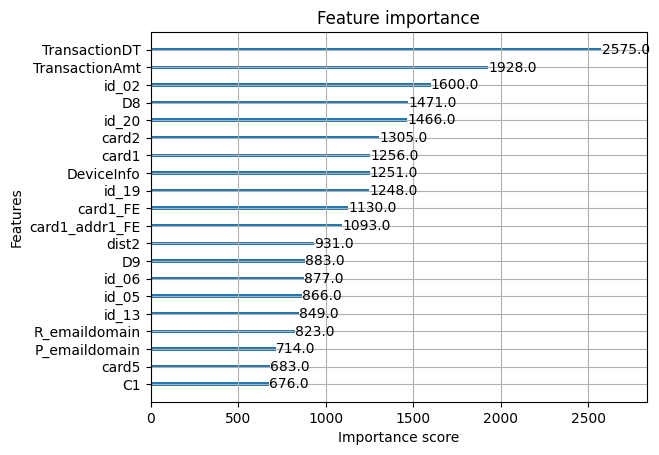

In [ ]:
xgb.plot_importance(clf_1, max_num_features=20)

In [ ]:


SECONDS_IN_DAY = 24 * 60 * 60

def build_uid(df: pd.DataFrame) -> pd.Series:
    """
    Builds a UID string that avoids leakage.
    UID = card1_addr1 + floor(day - D1)
    """
    out = df.copy()

    # day from TransactionDT
    day = (out["TransactionDT"] / SECONDS_IN_DAY)

    # card1_addr1 base
    card1 = out["card1"].astype("object").fillna("__NA__").astype(str)
    addr1 = out["addr1"].astype("object").fillna("__NA__").astype(str)
    card1_addr1 = card1 + "_" + addr1

    # D1 can be missing; handle safely
    if "D1" in out.columns:
        d1 = out["D1"].astype("float32")
        # If D1 missing, fall back to just floor(day)
        start_day = np.floor(day - d1).fillna(np.floor(day)).astype("int32")
    else:
        start_day = np.floor(day).astype("int32")

    uid = card1_addr1 + "_" + start_day.astype(str)
    return uid
def fit_uid_maps(train_df: pd.DataFrame, uid_col="UID"):
    """
    Returns frequency map for UID from TRAIN only.
    """
    uid_series = train_df[uid_col].astype("object")
    uid_fe_map = uid_series.value_counts().to_dict()
    return uid_fe_map
def add_uid_fe(df: pd.DataFrame, uid_fe_map, uid_col="UID"):
    out = df.copy()
    out["UID_FE"] = out[uid_col].map(uid_fe_map).fillna(0).astype("int32")
    return out
def fit_uid_aggs(train_df: pd.DataFrame, uid_col="UID"):
    """
    Fit aggregation tables on TRAIN only.
    Returns dict of DataFrames to merge later.
    """
    aggs = {}

    # TransactionAmt mean/std by UID
    amt = (
        train_df.groupby(uid_col)["TransactionAmt"]
        .agg(["mean", "std"])
        .reset_index()
        .rename(columns={
            "mean": "TransactionAmt_UID_mean",
            "std":  "TransactionAmt_UID_std"
        })
    )
    aggs["amt"] = amt

    # D9 mean/std by UID
    if "D9" in train_df.columns:
        d9 = (
            train_df.groupby(uid_col)["D9"]
            .agg(["mean", "std"])
            .reset_index()
            .rename(columns={
                "mean": "D9_UID_mean",
                "std":  "D9_UID_std"
            })
        )
        aggs["d9"] = d9


    return aggs
def apply_uid_features(df: pd.DataFrame, uid_fe_map, uid_aggs, uid_col="UID"):
    out = df.copy()

    # UID_FE
    out = add_uid_fe(out, uid_fe_map, uid_col=uid_col)

    # Merge TransactionAmt aggs
    out = out.merge(uid_aggs["amt"], on=uid_col, how="left")

    # Merge D9 aggs if available
    if "d9" in uid_aggs:
        out = out.merge(uid_aggs["d9"], on=uid_col, how="left")

    # Fill NaNs for mean/std with global fallbacks (safe)
    for c in ["TransactionAmt_UID_mean", "TransactionAmt_UID_std", "D9_UID_mean", "D9_UID_std"]:
        if c in out.columns:
            if c.endswith("_mean"):
                out[c] = out[c].fillna(out["TransactionAmt"].mean()).astype("float32")
            else:
                out[c] = out[c].fillna(out["TransactionAmt"].std()).astype("float32")

    return out



In [ ]:
# 1) Build UID for each split (no leakage)
X_tr = X_tr.copy()
X_val = X_val.copy()
X_test = X_val.copy()

X_tr["UID"] = build_uid(X_tr)
X_val["UID"] = build_uid(X_val)
X_test["UID"] = build_uid(X_test)

# 2) Fit maps on TRAIN ONLY
uid_fe_map = fit_uid_maps(X_tr, uid_col="UID")
uid_aggs = fit_uid_aggs(X_tr, uid_col="UID")

# 3) Apply to all splits
X_tr_uid = apply_uid_features(X_tr, uid_fe_map, uid_aggs, uid_col="UID")
X_val_uid = apply_uid_features(X_val, uid_fe_map, uid_aggs, uid_col="UID")
X_test_uid = apply_uid_features(X_test, uid_fe_map, uid_aggs, uid_col="UID")

# 4) IMPORTANT: drop raw UID before training (avoid overfit)
for df_ in (X_tr_uid, X_val_uid, X_test_uid):
    df_.drop(columns=["UID"], inplace=True, errors="ignore")

/tmp/ipython-input-2764442526.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  card1 = out["card1"].astype("object").fillna("__NA__").astype(str)
/tmp/ipython-input-2764442526.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  addr1 = out["addr1"].astype("object").fillna("__NA__").astype(str)
/tmp/ipython-input-2764442526.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_optio

In [ ]:


# 1) Build feature list (safe)

DROP_COLS = [
    "isFraud", "TransactionID",  # never train on these
    "UID"                        # never train on raw UID
]

def make_feature_matrix(df: pd.DataFrame, drop_cols=DROP_COLS):
    X = df.copy()
    cols_to_drop = [c for c in drop_cols if c in X.columns]
    X = X.drop(columns=cols_to_drop, errors="ignore")

    # Force numeric, replace inf, fill NaN
    X = X.apply(pd.to_numeric, errors="coerce")
    X = X.replace([np.inf, -np.inf], np.nan).fillna(-1)

    return X

#  already have these after UID engineering:
# X_tr_uid, X_val_uid, y_tr, y_val

Xtr = make_feature_matrix(X_tr_uid)
Xval = make_feature_matrix(X_val_uid)

features = Xtr.columns.tolist()
print("Training features:", len(features))
print("Train shape:", Xtr.shape, "Val shape:", Xval.shape)

# 2) Define model (same params)
clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    missing=np.nan,
    random_state=42
)


clf.fit(
    Xtr, y_tr,
    eval_set=[(Xval, y_val)],
    verbose=50,
    #early_stopping_rounds=50
)


# 4) Evaluate AUC
val_preds = clf.predict_proba(Xval)[:, 1]
val_auc = roc_auc_score(y_val, val_preds)
print("Validation AUC:", val_auc)

#  Train AUC (for overfit check)
train_preds = clf.predict_proba(Xtr)[:, 1]
train_auc = roc_auc_score(y_tr, train_preds)
print("Train AUC:", train_auc)




Training features: 443
Train shape: (142762, 443) Val shape: (1471, 443)
[0]	validation_0-auc:0.87006
[50]	validation_0-auc:0.94613
[100]	validation_0-auc:0.95179
[150]	validation_0-auc:0.95603
[200]	validation_0-auc:0.95846
[250]	validation_0-auc:0.95928
[300]	validation_0-auc:0.96043
[350]	validation_0-auc:0.96238
[400]	validation_0-auc:0.96304
[450]	validation_0-auc:0.96323
[499]	validation_0-auc:0.96332
Validation AUC: 0.9633201204498302
Train AUC: 0.9981790964016859


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

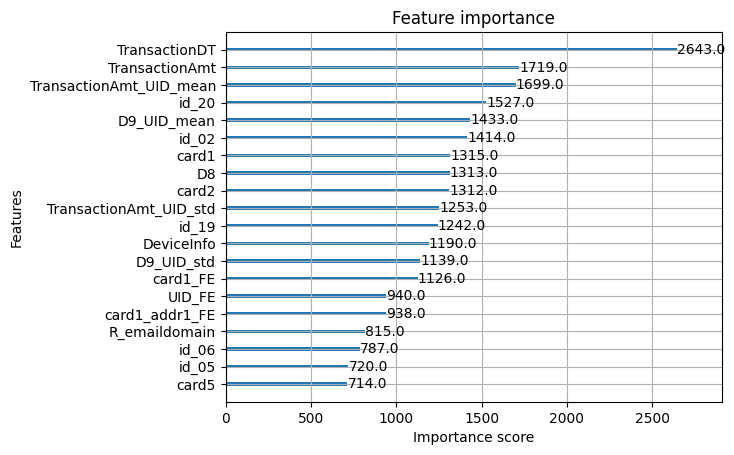

In [ ]:
xgb.plot_importance(clf, max_num_features=20)

In [ ]:


SECONDS_IN_DAY = 24 * 60 * 60

def add_month_group(df: pd.DataFrame, days_per_month=30):
    df = df.copy()
    df["month"] = (df["TransactionDT"] // (days_per_month * SECONDS_IN_DAY)).astype(int)
    return df

# ---- fold-safe UID step: only this block is "UID logic" ----
def add_fold_safe_uid_features(df_tr, df_va):
    df_tr = df_tr.copy()
    df_va = df_va.copy()

    df_tr["UID"] = build_uid(df_tr)
    df_va["UID"] = build_uid(df_va)

    uid_fe_map = fit_uid_maps(df_tr, uid_col="UID")
    uid_amt_table = fit_uid_aggs(df_tr, uid_col="UID")

    df_tr = apply_uid_features(df_tr, uid_fe_map, uid_amt_table, uid_col="UID")
    df_va = apply_uid_features(df_va, uid_fe_map, uid_amt_table, uid_col="UID")
    return df_tr, df_va

DROP_COLS_BASE = ["isFraud", "TransactionID", "UID", "month"]

def make_feature_matrix(df: pd.DataFrame, drop_cols=DROP_COLS_BASE):
    X = df.copy()
    X = X.drop(columns=[c for c in drop_cols if c in X.columns], errors="ignore")
    X = X.apply(pd.to_numeric, errors="coerce")
    X = X.replace([np.inf, -np.inf], np.nan).fillna(-1)
    return X

def align_cols(X_tr, X_va):
    """Ensure train/val have identical columns in same order."""
    cols = X_tr.columns.intersection(X_va.columns)
    return X_tr[cols], X_va[cols], cols.tolist()

def forward_month_cv(df_all: pd.DataFrame, params: dict, min_train_months=2, days_per_month=30):
    df_all = add_month_group(df_all, days_per_month=days_per_month)
    months = np.sort(df_all["month"].unique())

    aucs = []
    for i in range(min_train_months, len(months)):
        val_month = months[i]
        train_months = months[:i]

        df_tr = df_all.loc[df_all["month"].isin(train_months)].copy()
        df_va = df_all.loc[df_all["month"].eq(val_month)].copy()

        y_tr = df_tr["isFraud"].astype(int).values
        y_va = df_va["isFraud"].astype(int).values

        # only UID part happens here, fold-safe
        df_tr, df_va = add_fold_safe_uid_features(df_tr, df_va)

        X_tr = make_feature_matrix(df_tr)
        X_va = make_feature_matrix(df_va)

        # align columns (safe if some cols vanish in folds)
        X_tr, X_va, feat_cols = align_cols(X_tr, X_va)

        clf = xgb.XGBClassifier(**params)
        clf.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)


        preds = clf.predict_proba(X_va)[:, 1]
        auc = roc_auc_score(y_va, preds)
        aucs.append(auc)
        xgb.plot_importance(clf, max_num_features=20)

        print(f"Val month={int(val_month):>3} | train={len(df_tr):>7} | val={len(df_va):>6} | AUC={auc:.5f}")

    aucs = np.array(aucs)
    print("\nSummary:")
    print(f"Folds={len(aucs)} | Mean AUC={aucs.mean():.5f} | Std AUC={aucs.std():.5f} | "
          f"Min={aucs.min():.5f} | Max={aucs.max():.5f}")
    return aucs


/tmp/ipython-input-2764442526.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  card1 = out["card1"].astype("object").fillna("__NA__").astype(str)
/tmp/ipython-input-2764442526.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  addr1 = out["addr1"].astype("object").fillna("__NA__").astype(str)
/tmp/ipython-input-2764442526.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_optio

Val month=  2 | train=  73839 | val= 17328 | AUC=0.94903


/tmp/ipython-input-2764442526.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  card1 = out["card1"].astype("object").fillna("__NA__").astype(str)
/tmp/ipython-input-2764442526.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  addr1 = out["addr1"].astype("object").fillna("__NA__").astype(str)
/tmp/ipython-input-2764442526.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_optio

Val month=  3 | train=  91167 | val= 18210 | AUC=0.94193


/tmp/ipython-input-2764442526.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  card1 = out["card1"].astype("object").fillna("__NA__").astype(str)
/tmp/ipython-input-2764442526.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  addr1 = out["addr1"].astype("object").fillna("__NA__").astype(str)
/tmp/ipython-input-2764442526.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_optio

Val month=  4 | train= 109377 | val= 15116 | AUC=0.94319


/tmp/ipython-input-2764442526.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  card1 = out["card1"].astype("object").fillna("__NA__").astype(str)
/tmp/ipython-input-2764442526.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  addr1 = out["addr1"].astype("object").fillna("__NA__").astype(str)
/tmp/ipython-input-2764442526.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_optio

Val month=  5 | train= 124493 | val= 18269 | AUC=0.93289


/tmp/ipython-input-2764442526.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  card1 = out["card1"].astype("object").fillna("__NA__").astype(str)
/tmp/ipython-input-2764442526.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  addr1 = out["addr1"].astype("object").fillna("__NA__").astype(str)
/tmp/ipython-input-2764442526.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_optio

Val month=  6 | train= 142762 | val=  1471 | AUC=0.96574

Summary:
Folds=5 | Mean AUC=0.94656 | Std AUC=0.01090 | Min=0.93289 | Max=0.96574


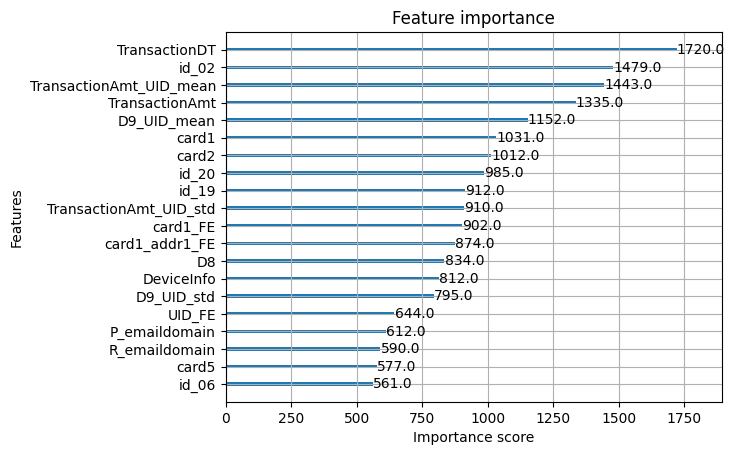

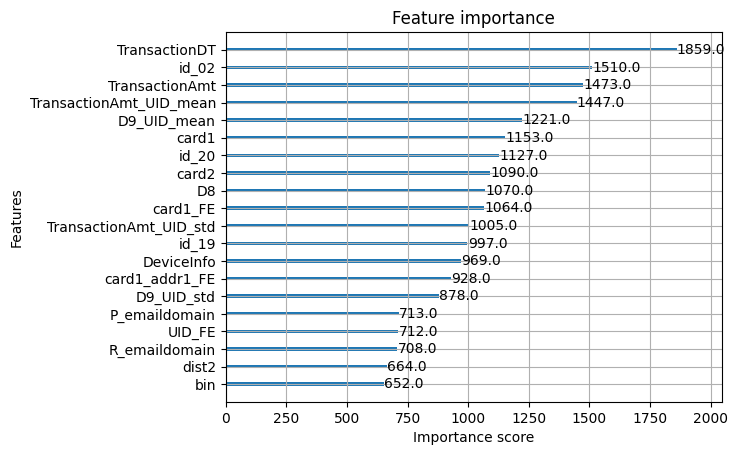

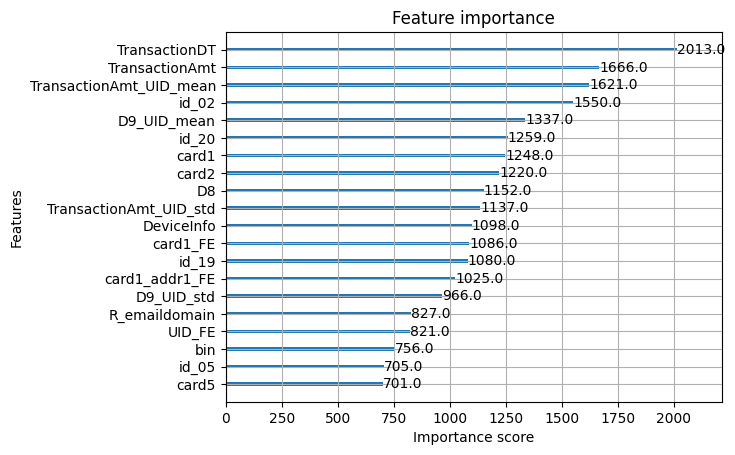

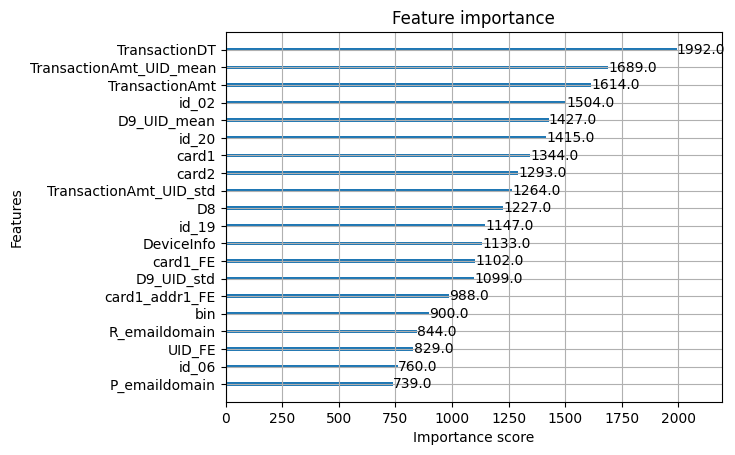

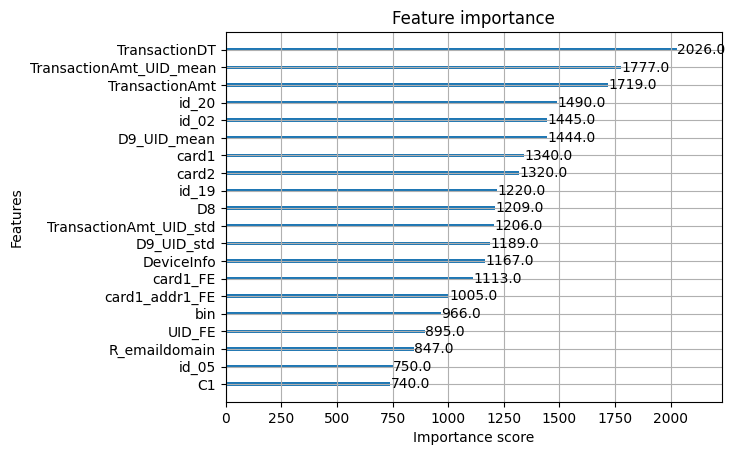

In [ ]:
df_all = X_train_processed.copy()
df_all["isFraud"] = y.values  # or y.loc[df_all.index].values if you want index-safe
params = dict(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    missing=np.nan,
    random_state=42
)

aucs = forward_month_cv(df_all, params=params, min_train_months=2)
